## Tensors

In [1]:
import torch
import numpy as np

# scalar, vector, matrix, tensor
scalar = torch.tensor(3.14159)
vector = torch.tensor([1, 2, 3])
matrix = torch.ones((2, 3), dtype=torch.float)
tensor = torch.randn((2, 3, 4), dtype=torch.float)
print(scalar)
print(vector)
print(matrix)
print(tensor)

# size, shape
print(tensor.size())
print(tensor.shape)

tensor(3.1416)
tensor([1, 2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[[-1.7296, -0.0713, -0.8480,  0.7516],
         [-0.2690, -0.7551, -1.0189, -2.1235],
         [ 0.5198, -0.5778, -0.7505, -0.8211]],

        [[ 0.0798,  1.3242, -0.4487, -1.1434],
         [ 0.2923, -2.3548,  0.3108,  0.0164],
         [-0.2069, -0.7507,  1.1054, -3.1943]]])
torch.Size([2, 3, 4])
torch.Size([2, 3, 4])


In [2]:
# view: share memory
same_matrix = matrix.view(1, 6)
same_matrix[0, 0] = 0
print(matrix)
print(same_matrix)

tensor([[0., 1., 1.],
        [1., 1., 1.]])
tensor([[0., 1., 1., 1., 1., 1.]])


In [3]:
# clone: copy memory, new_tensor: copy but not recommend
# matrix2 = matrix.new_tensor(matrix.view(1, 6))  # not recommend
matrix2 = matrix.view(1, 6).clone().detach()
matrix2[0, 0] = 1
print(matrix)
print(matrix2)

tensor([[0., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1.]])


## Load Data

In [4]:
np.random.seed(42)
x_train = np.random.rand(5, 1)

# as_tensor: share memory
# tensor: always create new tensor
x_train_tensor = torch.as_tensor(x_train)
print(x_train_tensor)
print(x_train.dtype, x_train_tensor.dtype)

tensor([[0.3745],
        [0.9507],
        [0.7320],
        [0.5987],
        [0.1560]], dtype=torch.float64)
float64 torch.float64


In [5]:
# float(), float64 -> float32
x_train_tensor_float = x_train_tensor.float()  # copy memory
x_train[0, 0] = 2
print(x_train_tensor)  # share: 2 appears
print(x_train_tensor_float)  # copy: 2 not appears

tensor([[2.0000],
        [0.9507],
        [0.7320],
        [0.5987],
        [0.1560]], dtype=torch.float64)
tensor([[0.3745],
        [0.9507],
        [0.7320],
        [0.5987],
        [0.1560]])


In [6]:
# numpy: share memory
x_train_numpy = x_train_tensor_float.numpy()
x_train_tensor_float[2, 0] = 3
print(x_train_numpy)

[[0.37454012]
 [0.9507143 ]
 [3.        ]
 [0.5986585 ]
 [0.15601864]]


In [7]:
# GPU
print(torch.cuda.is_available())
n_gpu = torch.cuda.device_count()
for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [8]:
# GPU tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpu_tensor = torch.as_tensor(x_train).float().to(device)
print(gpu_tensor)
print(type(x_train), type(gpu_tensor), gpu_tensor.type())

tensor([[2.0000],
        [0.9507],
        [0.7320],
        [0.5987],
        [0.1560]], device='cuda:0')
<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [9]:
# back to CPU
# back_cpu = gpu_tensor.numpy()  # okay if tensor is not on gpu
back_cpu = gpu_tensor.cpu().numpy()
print(back_cpu)

# Summary: GPU -> to(device), CPU -> cpu()

[[2.        ]
 [0.9507143 ]
 [0.7319939 ]
 [0.5986585 ]
 [0.15601864]]


## Parameters

In [10]:
# requires_grad: True -> gradient, False -> no gradient
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Attempt I: CPU
b = torch.randn(1, requires_grad=True, dtype=torch.float)
w = torch.randn(1, requires_grad=True, dtype=torch.float)
print(b, w)

# Attempt II: not work
b = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
w = torch.randn(1, requires_grad=True, dtype=torch.float).to(device)
print(b, w)

# Attempt III: work, too verbose
b = torch.randn(1, dtype=torch.float).to(device)
w = torch.randn(1, dtype=torch.float).to(device)
b.requires_grad_()  # in pytorch, suffix _ means in-place operation
w.requires_grad_()
print(b, w)

# Attempt IV: work, concise and recommended
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(b, w)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)
tensor([0.2345], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([0.2303], device='cuda:0', grad_fn=<ToCopyBackward0>)
tensor([-1.1229], device='cuda:0', requires_grad=True) tensor([-0.1863], device='cuda:0', requires_grad=True)
tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


## Autograd

In [11]:
true_b = 1
true_w = 2
N = 100
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_w * x + true_b + np.random.randn(N, 1) * 0.1
idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:int(N * 0.8)]
val_idx = idx[int(N * 0.8):]
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

torch.manual_seed(42)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
yhat = w * x_train_tensor + b
error = yhat - y_train_tensor
loss = (error ** 2).mean()
loss.backward()
print(error.requires_grad, yhat.requires_grad, w.requires_grad, b.requires_grad)
print(y_train_tensor.requires_grad, x_train_tensor.requires_grad)
print(b.grad, w.grad)

# no_grad: tells PyTorch not to track gradients
lr = 0.1
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
for epoch in range(1000):
    yhat = w * x_train_tensor + b
    error = yhat - y_train_tensor
    loss = (error ** 2).mean()
    loss.backward()
    with torch.no_grad():  # Key: 1. no_grad, 2. inplace operation
        b -= lr * b.grad
        w -= lr * w.grad
    b.grad.zero_()  # prevent default gradient accumulation
    w.grad.zero_()
print(b, w)

True True True True
False False
tensor([-3.3881], device='cuda:0') tensor([-1.9439], device='cuda:0')
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## Dynamic Computation Graph

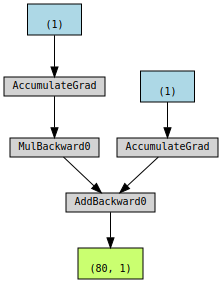

In [12]:
yhat = w * x_train_tensor + b
from torchviz import make_dot
make_dot(yhat)

## Optimizer

In [13]:
from torch import optim
lr = 0.1
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
optimizer = optim.SGD([b, w], lr=0.1)
print(optimizer)
for epoch in range(1000):
    yhat = w * x_train_tensor + b
    error = yhat - y_train_tensor
    loss = (error ** 2).mean()
    loss.backward()
    optimizer.step()  # Here is batch gradient descent, not its name SGD
    optimizer.zero_grad()
print(b, w)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## Loss

In [14]:
from torch import nn
lr = 0.1
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
optimizer = optim.SGD([b, w], lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')
print(loss_fn)
for epoch in range(1000):
    yhat = w * x_train_tensor + b
    loss = loss_fn(yhat, y_train_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
print(b, w)
# we can see scalar loss via the following methods
print(loss.detach().cpu().numpy())
print(loss.item())
print(loss.tolist())


MSELoss()
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)
0.008044656
0.008044656366109848
0.008044656366109848


## Model

In [15]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.w = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        return self.b + self.w * x

dummy = ManualLinearRegression()
print(list(dummy.parameters()))
print(dummy.state_dict())  # contains learnable parameters

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict({'b': tensor([0.3367]), 'w': tensor([0.1288])})


In [16]:
optimizer = optim.SGD([b, w], lr=lr)
print(optimizer.state_dict())  # contains hyperparameters

{'state': {}, 'param_groups': [{'lr': 0.1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]}


In [17]:
lr = 0.1
torch.manual_seed(42)
model = ManualLinearRegression().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')  # higher-order function
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()  # training mode, good practice to put in the loop
    yhat = model(x_train_tensor)  # not call forward() so hook works
    loss = loss_fn(yhat, y_train_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
print(model.state_dict())

OrderedDict({'b': tensor([1.0235], device='cuda:0'), 'w': tensor([1.9690], device='cuda:0')})


## Model Types

In [18]:
linear = nn.Linear(1, 1)
print(linear.state_dict())

OrderedDict({'weight': tensor([[-0.2191]]), 'bias': tensor([0.2018])})


In [19]:
class MyLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        self.linear(x)  # not self.linear.forward
dummy = MyLinearRegression().to(device)
print(list(dummy.parameters()))
print(dummy.state_dict())

[Parameter containing:
tensor([[-0.4869]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.5873], device='cuda:0', requires_grad=True)]
OrderedDict({'linear.weight': tensor([[-0.4869]], device='cuda:0'), 'linear.bias': tensor([0.5873], device='cuda:0')})


In [20]:
# For simple model in this example, we may use Sequential
model = nn.Sequential(nn.Linear(1, 1)).to(device)
print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.8815]], device='cuda:0'), '0.bias': tensor([-0.7336], device='cuda:0')})


## Layers

In [21]:
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)
print(model.state_dict())

OrderedDict({'0.weight': tensor([[ 0.5018,  0.1081,  0.4266],
        [ 0.0782,  0.2784, -0.0815],
        [ 0.4451,  0.0853, -0.2695],
        [ 0.1472, -0.2660, -0.0677],
        [-0.2345,  0.3830, -0.4557]], device='cuda:0'), '0.bias': tensor([-0.2662, -0.1630, -0.3471,  0.0545, -0.5702], device='cuda:0'), '1.weight': tensor([[ 0.4039, -0.3799,  0.3453,  0.0744, -0.1452]], device='cuda:0'), '1.bias': tensor([0.2764], device='cuda:0')})


In [22]:
model = nn.Sequential()
model.add_module('layer1', nn.Linear(3, 5))
model.add_module('layer2', nn.Linear(5, 1))
print(model.to(device))

Sequential(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)


## Summary

In [23]:
%%writefile datagen.py
true_b = 1
true_w = 2
N = 100
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (.1 * np.random.randn(N, 1))
idx = np.arange(N)
np.random.shuffle(idx)
train_idx = idx[:int(N*.8)]
val_idx = idx[int(N*.8):]
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Overwriting datagen.py


In [24]:
%%writefile datapre_v0.py
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

Overwriting datapre_v0.py


In [25]:
%%writefile model_v0.py
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1)).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_v0.py


In [26]:
%%writefile train_v0.py
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    yhat = model(x_train_tensor)
    loss = loss_fn(yhat, y_train_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Overwriting train_v0.py


In [27]:
%run -i datagen.py
%run -i datapre_v0.py
%run -i model_v0.py
%run -i train_v0.py
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9690]], device='cuda:0'), '0.bias': tensor([1.0235], device='cuda:0')})
